In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import glob
import itertools

In [2]:
%matplotlib widget

# Skeleton Drawing Function

Make a function that takes a pandas series/row and draws a skeleton on a given figure.

First a sequence to extract a set of responses, we need this mainly to just as an example of getting
start and end time stamps for a desired set of subject experiment responses.

In [3]:
# this sequence extracts a set of responses (button presses) for a given participant, posture and experiment block number
data_file = '../data/response-joint-displacements.csv'
subject_df = pd.read_csv(data_file)

# variables to select a participant and a portion of their experiment, so can
# extract start and stop time stamps
participant = 8
posture = 'sitting'
block_num = 1

mask = (subject_df.participant == participant) & (subject_df.posture == posture) & (subject_df.blockNum == block_num)
responses = subject_df[mask]

# for a single block number should be 49 responses, 1 buffer and 48 subsequent trials.
print(responses.shape)

# extract start and end times for this set of responses
num_responses = responses.shape[0]
start_time = responses.iloc[0]['utcTime']
start_time -= responses.iloc[0]['reactionTime'] + 1.0 # have to go back reactionTime + 1 sec to get to start of buffer trial 1
end_time = responses.iloc[num_responses-1]['utcTime']
print('num responses: ', num_responses)
print('   start_time: ',  start_time)
print('     end_time: ', end_time)

(42, 33)
num responses:  42
   start_time:  1636671511.70493
     end_time:  1636671752.8306985


In [4]:
# create lists of joint names to easily extract from Series/Dicts,
# these are used in the plot_skeleton() function
# extract joints into a set of variables for ease of use here
# position here corresponds to graph position, e.g.
# Head = 0, Neck = 1, Torso = 2, ..., RightFoot = 14
joint_names = [
    'Head', 'Neck', 'Torso',            # 0 1 2
    'LeftShoulder', 'RightShoulder',    # 3 4
    'LeftElbow', 'RightElbow',          # 5 6
    'LeftHand', 'RightHand',            # 7 8
    'LeftHip', 'RightHip',              # 9 10
    'LeftKnee', 'RightKnee',            # 11 12
    'LeftFoot', 'RightFoot'             # 13 14
]

# joint names of x, y, z positions respectively
x_joints = ['joint%sX' % name for name in joint_names]
y_joints = ['joint%sY' % name for name in joint_names]
z_joints = ['joint%sZ' % name for name in joint_names]

# a list of all joint names
joints = list(itertools.chain(x_joints, y_joints, z_joints))

Now extract kinect joint position information for this set of subject responses

In [5]:
file_pattern = '../data/%04d_*-joint-positions-displacements.csv' % participant
file_list = glob.glob(file_pattern)
data_file = file_list[0]

joint_df = pd.read_csv(data_file)

# create a timestamp as seconds since epoch, which matches the timestamp format from the subject responses
joint_df['utcTime'] = joint_df.utcMicrosecondsSinceEpoch / 1000000.0

# divide joint positions by 10 so we convert from mm to cm units, easier to understand.
joint_df[joints] = joint_df[joints] / 10.0

# extract data frame of these kinect joint positions for the responses of interest
mask = (joint_df.utcTime >= start_time) & (joint_df.utcTime <= end_time)
positions = joint_df[mask]
print('number of joint position measurements: ', positions.shape)
num_frames, _ = positions.shape
total_time = end_time - start_time
avg_frame_interval = int(total_time / num_frames * 1000) # as whole number of milliseconds
print('number of frames: ', num_frames)
print('total_time: ', total_time)
print('average frame interval: ', avg_frame_interval)

number of joint position measurements:  (7227, 63)
number of frames:  7227
total_time:  241.12576842308044
average frame interval:  33


At this point we have the desired kinect joint position measurements for a range of time for a given
subject's responses.  We want to animate these joint positions.

The following is a function that takes a single row and a 3D axis and plots the joint positions for that
single row/sample on the 3D plot.

In [6]:
# define joint graph used by plot_skeleton
# connect joints in following sequence, we use index 0=Head, 1=Neck, 2=Torso, ... 14=RightFoot
joint_graph = [
    (0, 1), (1, 3), (1, 4),          # head to neck, neck to shoulders
    (3, 5), (4, 6),                  # shoulders to elbows
    (5, 7), (6, 8),                  # elbows to hands
    (3, 2), (4, 2), (9, 2), (10, 2), # shoulders and hips to torso
    (3, 9), (4, 10), (9, 10),        # shoulders to hips, and connect hips
    (9, 11), (10, 12),               # hips to knees
    (11, 13), (12, 14),              # knees to feet
]
                   

def plot_skeleton(ax, joints):
    """We expect a Pandas series or dictionary like input of joint position
    information.  The series has features for jointHeadX, jointHeadY, etc.
    for the 15 joints.
    
    Parameters
    ----------
    ax - a 3D matplotlib axis on which to plot the joint positions
    joints - A Pandas series or dictionary like object with joint positions
       as features or keys of the expected names.
       
    Returns
    -------
    Nothing explicit is returned, but the joints are plotted on the given figure
    axis.
    """
    # pull out the x,y and z positions by joint names
    x_pos = joints[x_joints]
    y_pos = joints[y_joints]
    z_pos = joints[z_joints]

    # first scatter plot the joint positions as blue circle markers
    #fig_elements = ax.scatter(x_pos, y_pos, z_pos, 'bo')[0]
    fig_elements = [ax.plot(x, y, z, 'bo')[0] for x,y,z in zip(x_pos, y_pos, z_pos)] 
    
    # now plot the joint skeleton graph as red lines between joint positions
    for src, dst in joint_graph:
        line = ax.plot([x_pos[src], x_pos[dst]],
                      [y_pos[src], y_pos[dst]],
                      [z_pos[src], z_pos[dst]],
                      'r')[0]
        fig_elements.append(line)
        
    return fig_elements

In [7]:
joints = positions.iloc[0]
print(type(joints))
print(joints.index)

<class 'pandas.core.series.Series'>
Index(['userId', 'utcMicrosecondsSinceEpoch', 'jointHeadX', 'jointHeadY',
       'jointHeadZ', 'jointNeckX', 'jointNeckY', 'jointNeckZ',
       'jointLeftShoulderX', 'jointLeftShoulderY', 'jointLeftShoulderZ',
       'jointRightShoulderX', 'jointRightShoulderY', 'jointRightShoulderZ',
       'jointLeftElbowX', 'jointLeftElbowY', 'jointLeftElbowZ',
       'jointRightElbowX', 'jointRightElbowY', 'jointRightElbowZ',
       'jointLeftHandX', 'jointLeftHandY', 'jointLeftHandZ', 'jointRightHandX',
       'jointRightHandY', 'jointRightHandZ', 'jointTorsoX', 'jointTorsoY',
       'jointTorsoZ', 'jointLeftHipX', 'jointLeftHipY', 'jointLeftHipZ',
       'jointRightHipX', 'jointRightHipY', 'jointRightHipZ', 'jointLeftKneeX',
       'jointLeftKneeY', 'jointLeftKneeZ', 'jointRightKneeX',
       'jointRightKneeY', 'jointRightKneeZ', 'jointLeftFootX',
       'jointLeftFootY', 'jointLeftFootZ', 'jointRightFootX',
       'jointRightFootY', 'jointRightFootZ', 'jointHe

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
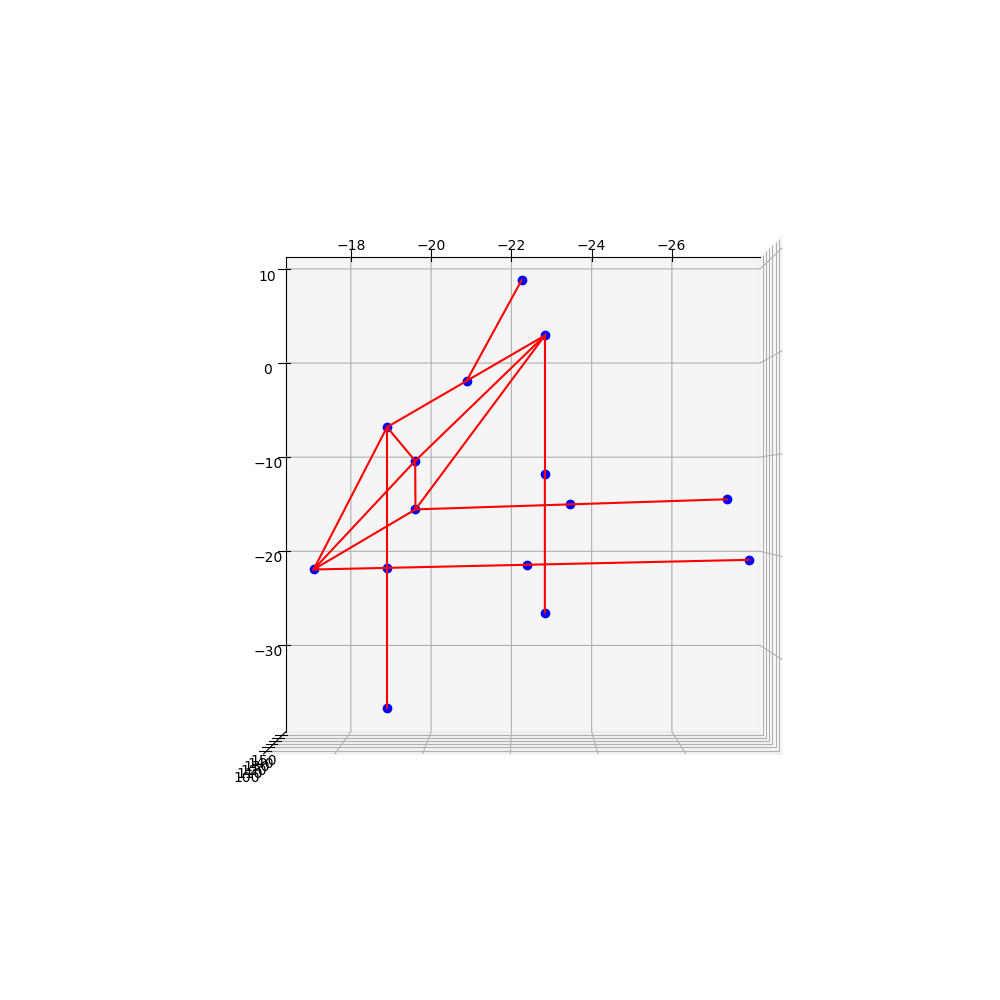

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

plot_skeleton(ax, joints)
ax.view_init(-90, 90)



# Animate Skeleton

Produce animation of skeleton joints for a given set of joint positions samples/frames/rows

In [9]:
def update_elements(num, positions, responses, ax):
    if num % 500 == 0:
        print('processing frame: ', num)
        
    # extract joint positions to plot
    joints = positions.iloc[num]
    
    # plot the joints
    ax.clear()
    updated_elements = plot_skeleton(ax, joints)
    ax.set_xlim3d([-70, 30])
    ax.set_ylim3d([-50, 50])
    ax.set_zlim3d([100, 200])
    
    # extract experiment response information for this time
    # the first response where response time is greater than this joint time is the response
    # block/trial we are in
    time = joints['utcTime']
    response = responses[responses.utcTime > time].iloc[0]
    if response.correct == 'yes':
        response_str = 'CORRECT'
    else:
        response_str = 'INCORRECT'
    title = 'Subject: %04d  condition: %02d\ntime: %s\nposture: %s block: %02d trial: %02d\n%s %s %s' % (
        response.participant,
        response.condition,
        pd.to_datetime(time,unit='s').strftime('%Y-%m-%d %H:%M:%S.%f'), 
        response.posture, 
        response.blockNum,
        response.trialNum,
        response_str,
        response.congruantTrialType,
        response.switchTrialType,
    )
    ax.set_title(title)
    ax.view_init(-90, 90)
    return updated_elements

processing frame:  0
processing frame:  0
processing frame:  500
processing frame:  1000
processing frame:  1500
processing frame:  2000
processing frame:  2500
processing frame:  3000
processing frame:  3500
processing frame:  4000
processing frame:  4500
processing frame:  5000
processing frame:  5500
processing frame:  6000
processing frame:  6500
processing frame:  7000


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
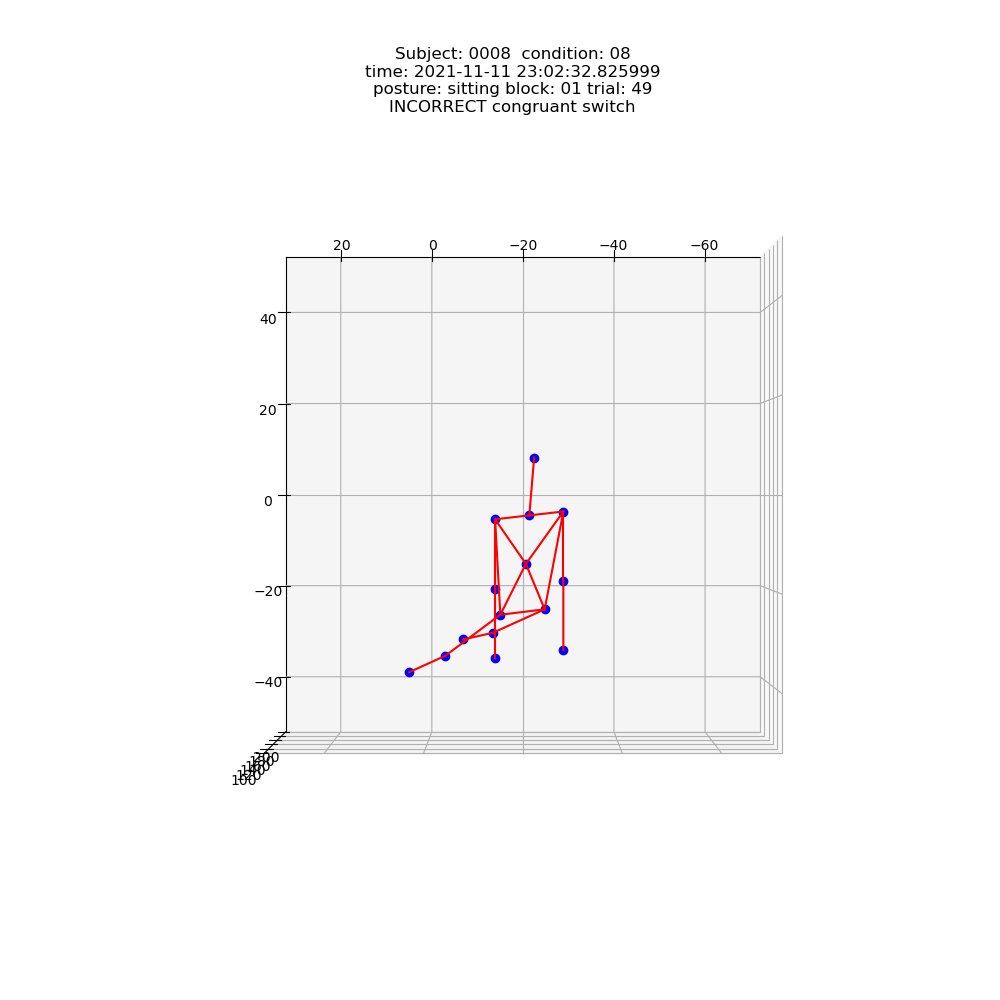

In [10]:
joints = positions.iloc[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

elements = plot_skeleton(ax, joints)
ax.set_xlim3d([-70, 30])
ax.set_ylim3d([-50, 50])
ax.set_zlim3d([100, 200])
ax.view_init(-90, 90)

# Creating the Animation object
elements_ani = animation.FuncAnimation(
    fig, update_elements, num_frames, fargs=(positions, responses, ax), interval=avg_frame_interval)

file_name = '%04d-%s-%02d.mov' % (participant, posture, block_num)
elements_ani.save(file_name)
